## Data preparation

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import copy

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from ipywidgets import interact

import torch
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
# Not all viewer can render interactive graph
# In that case, change the renderer to "svg" or "png"
pio.renderers.default = 'png'

### Import the dataset

Read the column description [here](data/Dummy_Marketing.txt)

In [3]:
df = pd.read_csv('data/Dummy_Marketing.csv')
df

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,Micro,94.685866
4568,71.0,20.610685,6.545573,Nano,249.101915
4569,44.0,19.800072,5.096192,Micro,163.631457
4570,71.0,17.534640,1.940873,Macro,253.610411


Note that other than using ready-made dataset, we can also use `torch.arange`, `torch.linspace`, and/or `torch.randn` to create linear data with noise

### Remove unwanted columns

We will practice simple linear regression, which only requires 2 variables

So we will just take the `Radio` as input feature ($x$) and `Sales` as target ($y$)

In [4]:
df = df[['Radio', 'Sales']]
df.head()

,Radio,Sales
0,6.566231,54.732757
1,9.237765,46.677897
2,15.886446,150.177829
3,30.020028,298.246340
4,8.437408,56.594181


### Remove null data

Check for null (empty) values first, then decide what to do next

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Radio   4568 non-null   float64
 1   Sales   4566 non-null   float64
dtypes: float64(2)
memory usage: 71.6 KB


Since there's only a few null values (out of 4572 rows), we can just drop them without affecting the data characteristic

In [6]:
df = df.dropna(ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Radio   4562 non-null   float64
 1   Sales   4562 non-null   float64
dtypes: float64(2)
memory usage: 71.4 KB


### Plot the data

Check whether linear regression is applicable or not

Also see Plotly plotting reference [here](https://plotly.com/python/) if needed

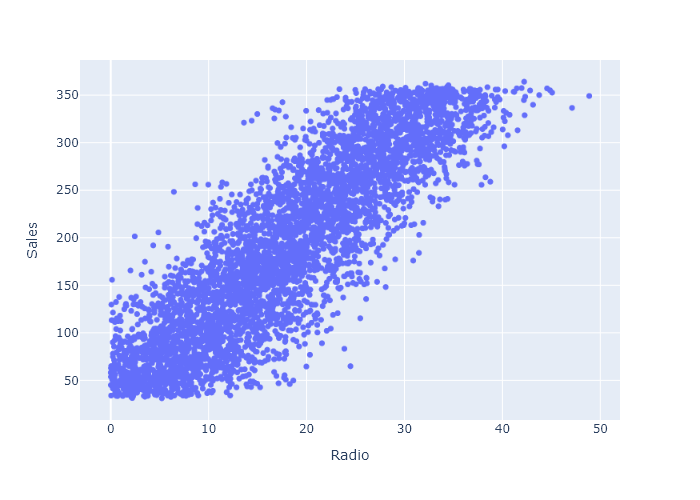

In [7]:
px.scatter(df, x = 'Radio', y = 'Sales')

We can also use [box plot](https://www.simplypsychology.org/boxplots.html) to check data distribution (median, etc) and outlier

Reference for Plotly multi-plotting [here](https://plotly.com/python/subplots/)

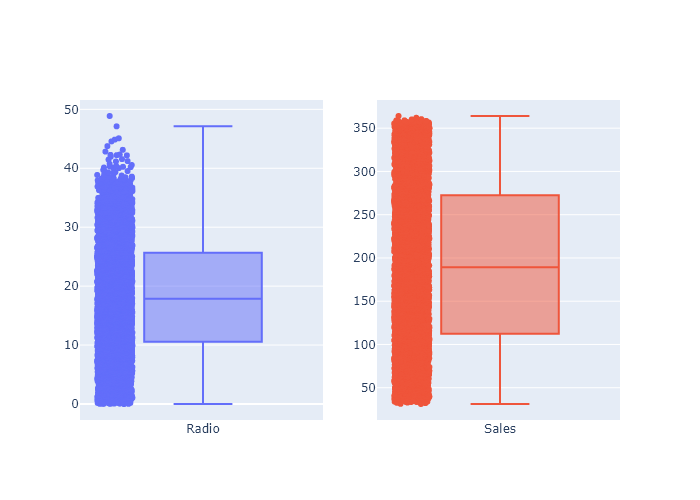

In [8]:
fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(
    go.Box(y = df['Radio'], name = 'Radio', boxpoints = 'all'),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = df['Sales'], name = 'Sales', boxpoints = 'all'),
    row = 1, col = 2
)

fig.update_layout(showlegend = False)
fig.show()

Seems good, we don't really need to remove outlier since there is only one or two

## Linear regression (from scratch)

Now before we begin, through linear regression, we want to create a line to predict sales like the output below

Mathematically, the equation for creating a straight line is $y = wx + b$ (aka $y = mx + c$)

Where:
- $w$ = weight (slope)
- $b$ = bias ($y$-axis intercept)
- $y$ = the target/prediction (sales)
- $x$ = the input/feature (radio promotion)

The $w$ and $b$ are the mysteries that we want to solve through linear regression

It's okay if you don't know $w$ and $b$ prior to this, but just remember that we need them both to make accurate predictions

In [9]:
fig1 = go.Figure()

# Can be changed via slider
x = np.arange(0, 51, 25)
w = 10
b = 25

fig1.add_traces([
    go.Scatter(
        x = df['Radio'].values,
        y = df['Sales'].values,
        mode = 'markers',
        name = 'Data points'
    ),
    go.Scatter(
        x = x,
        y = w * x + b,
        mode = 'lines',
        name = 'Prediction line'
    )
])

fig1.update_layout(
    title = f'y = {round(w, 2)}x + {b}',
    # Lock axis range so it won't move as we change the line
    xaxis_title_text = 'Radio (x)', xaxis_range = [-5, 50],
    yaxis_title_text = 'Sales (x)', yaxis_range = [-5, 400]
)

# https://plot.ly/python/v3/interact-decorator/
@interact(w = (0, 20, 0.5), b = (0, 50, 5))
def update(w = w, b = b):
    with fig1.batch_update():
        fig1.data[1].y = w * x + b
        fig1.update_layout(title = f'y = {round(w, 2)}x + {b}')

    fig1.show()

interactive(children=(FloatSlider(value=10.0, description='w', max=20.0, step=0.5), IntSlider(value=25, descri…

In the code above, we tried creating the best `Sales` prediction by changing $w$ and $b$ of the line formula ($y = wx + b$)

Notice that if we change $b$, the line $y$-position will be higher/lower. If we change $w$, the line slope will be more/less steep

The best fit for the line is obviously at the center of the data points (less prediction error)

We will explore how to calculate the error (loss) on the next section

### Calculating loss and cost

Using the $y = wx + b$ above, we can calculate the `Sales` prediction ($\hat{y}$)

For example, given $x$ (radio promotion) = 6.5 million, $w$ = 10, and $b$ = 25

Then the sales prediction is $wx + b = 10 \times 6.5 + 25 = 90$ million (see the first row on the table below)

In [10]:
# Parameter for y = wx + b
x = df['Radio'].values
w = 10
b = 25

df['Sales Prediction'] = w * x + b
df.head()

,Radio,Sales,Sales Prediction
0,6.566231,54.732757,90.662308
1,9.237765,46.677897,117.377646
2,15.886446,150.177829,183.864460
3,30.020028,298.246340,325.200283
4,8.437408,56.594181,109.374077


In the first row, we predicted 90m sales, but the real sales is 54m

To calculate the loss, we usually use the squared error formula:

$loss = (error)^2 = (\hat{y} - y)^2$

Where:
- $\hat{y}$ = sales prediction
- $y$ = real sales

So the loss for the first row is $(90 - 54)^2 = 1290$

We use power of 2 so that the result is always positive, so $(90 - 54)^2$ will be the same as $(54 - 90)^2$

In [11]:
# Loss using squared error
df['Loss'] = (df['Sales Prediction'] - df['Sales']) ** 2
df.head()

,Radio,Sales,Sales Prediction,Loss
0,6.566231,54.732757,90.662308,1290.932616
1,9.237765,46.677897,117.377646,4998.454465
2,15.886446,150.177829,183.864460,1134.789135
3,30.020028,298.246340,325.200283,726.515032
4,8.437408,56.594181,109.374077,2785.717424


The collection of these losses is called cost (which is usually the sum or mean of all losses)

Since we are going to use mean, our cost function become [mean squared error]((https://www.freecodecamp.org/news/machine-learning-mean-squared-error-regression-line-c7dde9a26b93/)) (MSE):

$J = \frac{1}{n}\sum_i^n ((wx + b) - y)^2$

$J = \frac{1}{n}\sum_i^n (\hat{y} - y)^2$

$J = \frac{1}{n}\sum_i^n loss$

Or simply

$J = \frac{sum(loss)}{n} = avg(loss) $

Where:
- $J$ = symbol of cost function
- $\hat{y}$ = sales prediction
- $y$ = real sales
- $n$ = number of rows (you can also use [$2n$ instead of $n$](https://math.stackexchange.com/questions/884887/why-divide-by-2m))

Note: The result of cost ($J$) depends on the value of $w$ and $b$, so it's also refered as $J(w,b)$ in most literature

In [12]:
# Average (mean) of loss
print('Cost (MSE):')
np.mean(df['Loss'].values)

Cost (MSE):


2570.309237238925

Now let's try figuring the line again, but this time using cost as the measure

Lower cost means better prediction (more accurate)

In [13]:
def compute_error(df: pd.DataFrame, w, b):
    x = df['Radio'].values

    # Real sales (y)
    y = df['Sales'].values
    # Sales prediction (y-hat)
    yhat = w * x + b

    # Error
    return yhat - y

def compute_cost(df: pd.DataFrame, w, b, method = 'mse'):
    error = compute_error(df, w, b)

    # Absolute error loss
    if method.lower() == 'mae': loss = np.abs(error)
    # Squared error loss
    else: loss = error ** 2

    # Cost
    return np.mean(loss)

In [14]:
# Code is the same as before
# I just added the cost calculation

fig2 = go.Figure()

x = np.arange(0, 51, 25)
w = 10
b = 25

fig2.add_traces([
    go.Scatter(
        x = df['Radio'].values,
        y = df['Sales'].values,
        mode = 'markers',
        name = 'Data points'
    ),
    go.Scatter(
        x = x,
        y = w * x + b,
        mode = 'lines',
        name = 'Prediction line'
    )
])

fig2.update_layout(
    title = f'y = {round(w, 2)}x + {b}',
    xaxis_title_text = 'Radio (x)', xaxis_range = [-5, 50],
    yaxis_title_text = 'Sales (x)', yaxis_range = [-5, 400]
)

@interact(w = (0, 20, 0.5), b = (0, 50, 5))
def update(w = w, b = b):
    with fig2.batch_update():
        fig2.data[1].y = w * x + b
        fig2.update_layout(
            title = f'y = {round(w, 2)}x + {b}<br>' +
                f'Cost = {round(compute_cost(df, w, b), 3)}'
        )

    fig2.show()

interactive(children=(FloatSlider(value=10.0, description='w', max=20.0, step=0.5), IntSlider(value=25, descri…

So.. what is the best equation that produced minimum cost, based on your experiment?

If your equation is quite accurate, it will be located at the bottom of the bowl shape below

In [15]:
# Cool reference you might be interested on
# https://www.kaggle.com/code/mwaseem75/cost-function-for-linear-regression

def generate_cost_zaxis(df: pd.DataFrame, w: np.array, b: np.array, method = 'mse'):
    # We must use meshgrid to generate the Z-axis
    # Otherwise, the graph won't have a paper-like layer (just blank)
    # The result, w_grid and b_grid, will always have the same shape
    w_grid, b_grid = np.meshgrid(w, b)
    costs = np.zeros_like(w_grid)

    for i in range(w_grid.shape[0]):
        for j in range(w_grid.shape[1]):
            # Compute cost (J) for every combination of w and b (bruteforce)
            costs[i,j] = compute_cost(df, w_grid[i][j], b_grid[i][j], method)

    return costs

In [16]:
fig3 = go.Figure()

# Weight range to bruteforce
w = np.arange(0, 20, 0.5)
# Bias range to bruteforce
b = np.arange(0, 50, 5)

# Cost, can be MSE or MAE
cost_fm = 'MSE'
costs = generate_cost_zaxis(df, w, b, cost_fm)

fig3.add_traces([
    go.Surface(
        x = w,
        y = b,
        z = costs,
        # Show y = wx + b and cost (J) on hover
        # Instead of individual x, y, z axis
        hovertemplate = \
            'y = %{x}x + %{y}<br>' +
            'J(w,b) = %{z}<extra></extra>'
    ),
    go.Scatter3d(
        x = [10],
        y = [25],
        z = [2570],
        mode = 'markers',
        marker_color = 'cyan'
    )
])

fig3.update_scenes(
    xaxis_title_text = 'w',
    yaxis_title_text = 'b',
    zaxis_title_text = 'J(w,b)'
)

@interact(w = (0, 20, 0.5), b = (0, 50, 5), view = ['w-axis', 'b-axis'])
def update(w = w, b = b, view = 'w-axis'):
    with fig3.batch_update():
        cost = compute_cost(df, w, b, cost_fm)

        fig3.data[1].x = [w]
        fig3.data[1].y = [b]
        fig3.data[1].z = [cost]

        # https://stackoverflow.com/q/35478791/grab-camera-position
        if view == 'w-axis':
            fig3.update_scenes(camera_eye = dict(x = 0.03, y = -2.3, z = 0.4))
        elif view == 'b-axis':
            fig3.update_scenes(camera_eye = dict(x = -2.16, y = -0.1, z = 0.1))

        fig3.update_layout(
            title = f'y = {round(w, 2)}x + {b}<br>' +
                f'Cost ({cost_fm}) = {round(cost, 3)}'
        )

    fig3.show()

interactive(children=(FloatSlider(value=10.0, description='w', max=20.0, step=0.5), IntSlider(value=25, descri…

As you can see above, we can draw the relation between $w$, $b$, and cost ($J$) on a 3D graph:
- $w$ (weight) = the $x$-axis
- $b$ (bias) = the $y$-axis
- $J$ (cost) = the $z$-axis

Turns out a bad $y = wx + b$ equation will produce higher cost ($J$) and will be at the upper side of the bowl

While a good equation will produce minimum cost ($J$) and will be located at the bottom of the bowl

I didn't make up this rule or the bowl shape by the way, it's a naturally formed relation between $w$, $b$, and cost ($J$)

### Gradient descent theory

Other than brute forcing $w$ and $b$ to find the best cost (like the 3D graph above), we can also use the gradient descent algorithm

Gradient descent gradually changes the $w$ and $b$ by using parameter $\alpha$ (learning rate) to reach the bottom of the hill

But before that, we need to learn the basic theory first

#### Theory: slope (gradient)

You may have learned about slope (steepness of a line) in high school before

The formula for slope ($w$) is $\frac{\Delta y}{\Delta x}$ (the rise of $y$-axis over the run of $x$-axis)

Imagine you're a hiker and take a look at the 3D graph above. Your initial position is at the top of the hill ($x_0, y_0$)

The slope will be pretty steep as we go downhill from the top ($\frac{x_0 - x_1}{y_0 - y_1}$), and it will be difficult to maintain your balance at that position

But when we reach the bottom itself, it's no longer steep, it will be level since we can stand on it without problem

This means that slope at the bottom of hill is 0, but the slope before that (as we go downhill) is not 0

#### Theory: derivative

The easiest way to find the slope of a line at any given position is by using derivative

For example we have the equation $f(x) = x^2 + 4x + 1$, and we want to find the slope at $x = 2$

So the steps to find the slope of $f(x)$ at $x = 2$ are just:

$f(x) = x^2 + 4x + 1$ \
$f'(x) = 2x + 4$ \
$f'(2) = 2 \times 2 + 4 = 8$

To visualize $x$ and $f(x)$ you can check the 2D graph [here](https://www.desmos.com/calculator/ic3dyendeb)

#### Theory: partial derivative

Partial derivative is basically the same as derivative

But instead of having one variable $f(x)$, we have 2 or more variables, e.g. $f(x,y)$

The easiest example of $f(x,y)$ is our cost function $J(w,b)$:

$J(w,b) = \frac{1}{n}\sum_i^n loss$ \
$J(w,b) = \frac{1}{n}\sum_i^n (\hat{y} - y)^2$ \
$J(w,b) = \frac{1}{n}\sum_i^n (wx + b - y)^2$

So the partial derivative of $w$ for $J(w,b)$ is:

$J(w,b) = \frac{1}{n}\sum_i^n (wx + b - y)^2$ \
$\frac{\partial}{\partial w} J(w,b) = \frac{1}{n}\sum_i^n 2(wx + b - y)x$, or simply \
$J(w,b) = avg(2 \times error \times x)$

And the partial derivative of $b$ for $J(w,b)$ is:

$J(w,b) = \frac{1}{n}\sum_i^n (wx + b - y)^2$ \
$\frac{\partial}{\partial b} J(w,b) = \frac{1}{n}\sum_i^n 2(wx + b - y)$, or simply \
$J(w,b) = avg(2 \times error)$

If you're confused, see the [rule of derivative](https://www.mathsisfun.com/calculus/derivatives-rules.html) again, or just use a smart calculator to check

To visualize $w$, $b$, and $J(w,b)$, we will need a 3D graph like we did before, and using partial derivative means [slicing the 3D graph into 2D](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivatives/v/partial-derivatives-and-graphs)

If we use partial derivative of $w$ ($\frac{\partial}{\partial w} J(w,b)$), then we are slicing the $b$-axis of 3D graph at specific $b$ value, resulting 2D view of $w$ and $J(w,b)$

And if we use partial derivative of $b$ ($\frac{\partial}{\partial b} J(w,b)$), then we are slicing the $w$-axis of 3D graph at specific $w$ value, resulting 2D view of $b$ and $J(w,b)$

See the 2D graph below for the slicing visualization, and compare with the previous 3D graph if necessary

In [17]:
# Moving w but constant b
def compute_costs_w(df: pd.DataFrame, w: np.array, b, method = 'mse'):
    costs = np.zeros_like(w)
    for i in range(len(w)):
        costs[i] = compute_cost(df, w[i], b, method)
    return costs

# Moving b but constant w
def compute_costs_b(df: pd.DataFrame, w, b: np.array, method = 'mse'):
    costs = np.zeros_like(b)
    for i in range(len(b)):
        costs[i] = compute_cost(df, w, b[i], method)
    return costs

def compute_slope_w(df: pd.DataFrame, w, b, method = 'mse'):
    x = df['Radio'].values
    error = compute_error(df, w, b)

    # Partial derivative w of cost function (J)
    if method.lower() == 'mae': dw = np.mean(x)
    else: dw = np.mean(2 * error * x)

    return round(dw)

def compute_slope_b(df: pd.DataFrame, w, b, method = 'mae'):
    error = compute_error(df, w, b)

    # Partial derivative b of cost function (J)
    if method.lower() == 'mae': db = 1
    else: db = np.mean(2 * error)

    return round(db)

In [18]:
# 2D view for demonstrating partial derivative
# See the 3D graph for comparison

fig4 = make_subplots(
    rows = 1, cols = 2,
    shared_yaxes = True,
    subplot_titles = [
        'Side-view from w',
        'Side-view from b'
    ]
)

# Constant w and b value (for the marker)
w, b = 10, 25
# Moving w and b arrays (for the line)
w_arr = np.arange(0, 20, 0.5)
b_arr = np.arange(0, 50, 5)
cfm = 'MSE'

fig4.add_traces(
    [
        # Lines
        go.Scatter(
            x = w_arr,
            y = compute_costs_w(df, w_arr, b, cfm),
            showlegend = False,
            mode = 'lines'
        ),
        go.Scatter(
            x = b_arr,
            y = compute_costs_b(df, w, b_arr, cfm),
            showlegend = False,
            mode = 'lines'
        ),
        # Markers
        go.Scatter(
            x = [w],
            y = [compute_cost(df, w, b, cfm)],
            showlegend = False,
            mode = 'markers'
        ),
        go.Scatter(
            x = [b],
            y = [compute_cost(df, w, b, cfm)],
            showlegend = False,
            mode = 'markers'
        )
    ],
    rows = [1, 1, 1, 1],
    cols = [1, 2, 1, 2]
)

fig4.layout.yaxis.title = 'J(w,b)'
fig4.layout.xaxis.title = 'w'
fig4.layout.yaxis2.title = 'J(w,b)'
fig4.layout.xaxis2.title = 'b'

@interact(w = (0, 20, 0.5), b = (0, 50, 5))
def update(w = w, b = b):
    with fig4.batch_update():
        # Update the lines
        fig4.data[0].x = w_arr
        fig4.data[0].y = compute_costs_w(df, w_arr, b, cfm)
        fig4.data[1].x = b_arr
        fig4.data[1].y = compute_costs_b(df, w, b_arr, cfm)

        # Update the markers
        fig4.data[2].x = [w]
        fig4.data[2].y = [compute_cost(df, w, b, cfm)]
        fig4.data[3].x = [b]
        fig4.data[3].y = [compute_cost(df, w, b, cfm)]

        fig4.layout.annotations[0].text = f'Side-view from w (Slope: {compute_slope_w(df, w, b)})'
        fig4.layout.annotations[1].text = f'Side-view from b (Slope: {compute_slope_b(df, w, b)})'

        fig4.update_layout(title = f'y = {round(w, 2)}x + {b}')

    fig4.show()

interactive(children=(FloatSlider(value=10.0, description='w', max=20.0, step=0.5), IntSlider(value=25, descri…

Why do we need partial derivative of $w$ and $b$ from our cost function ($J$)?
- Remember that the goal of derivative (and partial derivative) is to find the slope of a line
- And we want to reach the bottom of the hill (where the slope is 0) to achieve the best cost and prediction
- So we can change our $w$ and $b$ systematically using derivative until we reach the slope 0 (or near 0)
- See the 3D graph again for reference

### Gradient descent implementation

Gradient descent makes use of α (learning rate) to gradually change $w$ and $b$ until it reaches convergence (the bottom of the hill)

The steps of gradient descent are basically like this:
1. Take an input α (learning rate), which is usually a very small number (e.g. 0.001)
2. Initialize $w$ and $b$ randomly (or by assigning zero to both of them)
3. Reduce $w$ and $b$ by α on each iteration:

    $w\_new = w - \alpha \times \frac{\partial}{\partial w} J(w,b)$ \
    $b\_new = b - \alpha \times \frac{\partial}{\partial b} J(w,b)$ \
    $w = w\_new$ \
    $b = b\_new$

    Where:
    - $\frac{\partial}{\partial w}$ = partial derivative of $w$
    - $\frac{\partial}{\partial b}$ = partial derivative of $b$
    - $J(w,b)$ = cost function (with $w$ and $b$ as input)
    - $\alpha$ = learning rate (lr)
    
    Note:
    - $w$ and $b$ must be updated simultaneously after calculating both derivative, not $w$ first then $b$ or vice versa
    - It's because the cost function requires both $w$ and $b$ as the parameter ($J(w,b)$), so updating one value only will make the result incorrect

In [19]:
def gradient_descent(df, w_init = 0, b_init = 0, method = 'mse', lr = 0.001, iter = 100):
    w = w_init
    b = b_init

    # History for each iteration
    j_hist = np.zeros(iter)
    w_hist = np.zeros(iter)
    b_hist = np.zeros(iter)

    for i in range(iter):
        w_hist[i] = w
        b_hist[i] = b
        j_hist[i] = compute_cost(df, w, b, method)

        # Partial derivative of w and b from cost function
        dw = compute_slope_w(df, w, b, method)
        db = compute_slope_b(df, w, b, method)

        w = w - lr * dw
        b = b - lr * db

        print(
            # Since we are using whole data on each iteration
            # Then 1 iteration is also the same as 1 epoch
            # This is called batch gradient descent
            f'Iter: {i + 1}, ' +
            f'dw: {dw:.3f}, db: {db:.3f}, ' +
            f'w: {w_hist[i]:.3f}, b: {b_hist[i]:.3f}, ' +
            f'Cost: {j_hist[i]:.3f}'
        )

        # If we can no longer decrease the slope
        if dw == 0 and db == 0:
            print('Stopping early...')
            # Slice the array size to last iteration
            w_hist = w_hist[:i]
            b_hist = b_hist[:i]
            j_hist = j_hist[:i]
            break

    return w_hist, b_hist, j_hist

w_hist, b_hist, j_hist = gradient_descent(df, w_init = 0, b_init = 0, lr = 0.001, iter = 10000)

Iter: 1, dw: -8556.000, db: -385.000, w: 0.000, b: 0.000, Cost: 45705.243
Iter: 2, dw: -1297.000, db: -73.000, w: 8.556, b: 0.385, Cost: 3468.939
Iter: 3, dw: -196.000, db: -26.000, w: 9.853, b: 0.458, Cost: 2497.500
Iter: 4, dw: -29.000, db: -19.000, w: 10.049, b: 0.484, Cost: 2474.909
Iter: 5, dw: -4.000, db: -18.000, w: 10.078, b: 0.503, Cost: 2474.090
Iter: 6, dw: 0.000, db: -18.000, w: 10.082, b: 0.521, Cost: 2473.764
Iter: 7, dw: 1.000, db: -18.000, w: 10.082, b: 0.539, Cost: 2473.446
Iter: 8, dw: 1.000, db: -18.000, w: 10.081, b: 0.557, Cost: 2473.128
Iter: 9, dw: 1.000, db: -18.000, w: 10.080, b: 0.575, Cost: 2472.809
Iter: 10, dw: 1.000, db: -18.000, w: 10.079, b: 0.593, Cost: 2472.491
Iter: 11, dw: 0.000, db: -18.000, w: 10.078, b: 0.611, Cost: 2472.173
Iter: 12, dw: 1.000, db: -18.000, w: 10.078, b: 0.629, Cost: 2471.856
Iter: 13, dw: 1.000, db: -18.000, w: 10.077, b: 0.647, Cost: 2471.538
Iter: 14, dw: 1.000, db: -18.000, w: 10.076, b: 0.665, Cost: 2471.221
Iter: 15, dw: 0.

Now let's see the best equation (that minimize cost) according to gradient descent

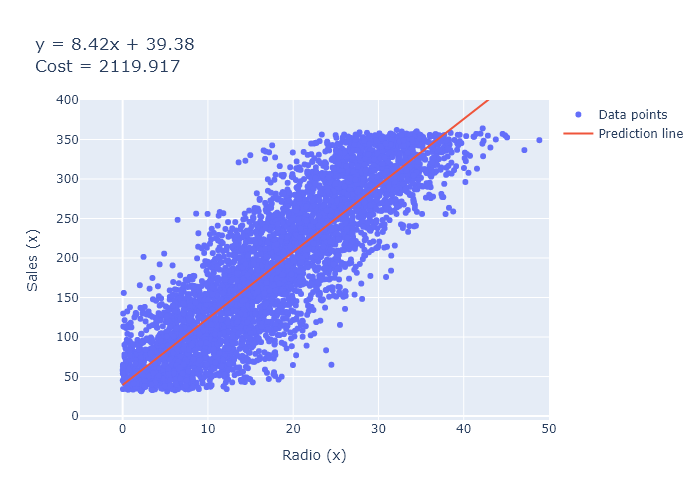

In [20]:
fig = copy.deepcopy(fig2)

w = w_hist[-1]
b = b_hist[-1]
j = j_hist[-1]

with fig.batch_update():
    fig.data[1].y = w * x + b
    fig.update_layout(
        title = f'y = {round(w, 2)}x + {round(b, 2)}<br>' +
            f'Cost = {round(j, 3)}'
    )

fig.show()

Neat, so the line is not exactly on the center of the data points

I think it's due to by the outliers at the right part of the $x$-axis, so we can conclude that linear regression is sensitive to outlier

Now, let's see the visualization of the gradient descent itself (see below)

In [21]:
fig5 = copy.deepcopy(fig3)

@interact(iter = (0, len(w_hist) - 1, 1), view = ['w-axis', 'b-axis'])
def update(iter = 0, view = 'w-axis'):
    w = w_hist[iter]
    b = b_hist[iter]
    j = j_hist[iter]

    with fig5.batch_update():
        fig5.data[1].x = [w]
        fig5.data[1].y = [b]
        fig5.data[1].z = [j]

        # https://stackoverflow.com/q/35478791/grab-camera-position
        if view == 'w-axis':
            fig5.update_scenes(camera_eye = dict(x = 0.03, y = -2.3, z = 0.4))
        elif view == 'b-axis':
            fig5.update_scenes(camera_eye = dict(x = -2.16, y = -0.1, z = 0.1))

        fig5.update_layout(
            title = f'y = {round(w, 2)}x + {round(b, 2)}<br>' +
                f'Cost ({cost_fm}) = {round(j, 3)}'
        )

    fig5.show()

interactive(children=(IntSlider(value=0, description='iter', max=7783), Dropdown(description='view', options=(…

Note: You can use the arrow key if the slider change is too sensitive

It turns out that after the initial change, our position are already somewhere at the bottom of the hill

So each iteration is just us moving slightly the other side of the bottom (which the slope is slightly more level than our initial position)

## Linear regression (PyTorch way)

Now we will try to implement linear regression using PyTorch framework

But this time we will use all the input features (radio, tv, and social media)

And assume that these features are all linear (without visualizing it)

In [22]:
df = pd.read_csv('data/Dummy_Marketing.csv')
df = df.dropna(ignore_index = True)
df = df.drop('Influencer', axis = 1)

print(df.shape)
df.head()

(4546, 4)


,TV,Radio,Social Media,Sales
0,16.0,6.566231,2.907983,54.732757
1,13.0,9.237765,2.409567,46.677897
2,41.0,15.886446,2.913410,150.177829
3,83.0,30.020028,6.922304,298.246340
4,15.0,8.437408,1.405998,56.594181


### Converting data to tensor

The data need to be converted to tensor first so we can process it through PyTorch

The recommended way to achieve this is by creating a custom `Dataset` class, which allows us to do few extra things as well

See reference about [magic methods](https://realpython.com/python-magic-methods/), [tensor](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), and [dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [23]:
class SalesDataset(data_utils.Dataset):
    def __init__(self, x, y, transform = None, target_transform = None):
        # Feature and target (both can be more than 1 column)
        # However, dimension must be 2D even if there's only 1 column
        self.x = x
        self.y = y

        # Function to transform feature (scaling, rotation, etc)
        self.transform = transform
        # Same as above but for target (y)
        self.target_transform = target_transform

    def __getitem__(self, index):
        sample_x = self.x[index]
        sample_y = self.y[index]

        # Transform data first before returning item
        if self.transform:
            sample_x = self.transform(sample_x)
        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        # Return a tuple containing feature and target
        return (sample_x, sample_y)

    def __len__(self):
        # x and y should have the same number of rows
        # So it doesn't matter whether we use x or y
        return self.y.shape[0]

# Simple transform module for practice
class NumpyToTensor(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, array: np.ndarray):
        return torch.tensor(array, dtype = torch.float32)

The class above is just a declaration, we initialize it below

In [24]:
# Columns for feature and target
x_cols = ['TV', 'Radio', 'Social Media']
y_cols = ['Sales']

ds = SalesDataset(
    # We should use 2D tensor even if we only have 1 feature/target
    # That's why we use square brackets again to wrap "x_cols" and "y_cols"
    x = df[x_cols].values,
    y = df[y_cols].values,
    # Convert data type from numpy to tensor as preprocessing step
    # Use "transform.Compose" if you need multiple transformations
    # https://pytorch.org/vision/stable/transforms.html
    transform = NumpyToTensor(),
    target_transform = NumpyToTensor()
)

# Check if the dataset get the number of rows correctly
print('1:', len(df))
print('2:', len(ds))

# Check if the dataset get the first 3 rows correctly
# The dataframe will return feature and target combined
# While the dataset will return feature first then target
print('3:', df.iloc[0:3].values)
print('4:', ds[0:3])

1: 4546
2: 4546
3: [[ 16.           6.56623079   2.90798277  54.73275715]
 [ 13.           9.23776457   2.4095672   46.67789698]
 [ 41.          15.88644602   2.91341018 150.1778288 ]]
4: (tensor([[16.0000,  6.5662,  2.9080],
        [13.0000,  9.2378,  2.4096],
        [41.0000, 15.8864,  2.9134]]), tensor([[ 54.7328],
        [ 46.6779],
        [150.1778]]))


Seems correct, let's continue to the next step

### Creating linear regression model

We will try creating linear regression model from scratch

In [25]:
# Poor man's implementation of "torch.nn.Linear"

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize tensor of w and b with value 1
        # Values will be changed later through training
        self.weight = torch.nn.Parameter(
            torch.ones(size = (out_features, in_features)),
            requires_grad = True
        )
        self.bias = torch.nn.Parameter(
            torch.ones(size = (out_features,)),
            requires_grad = True
        )

    def reset_parameters(self):
        # Reset weight and bias if needed
        torch.nn.init.ones_(self.weight)
        torch.nn.init.ones_(self.bias)

    # Sales prediction (yhat)
    def forward(self, x: torch.Tensor):
        # The number of predictions (y) should match the number of input rows and the output
        # So if we want to predict sales of 100 data, the shape will be (100, 1)
        # If we want to predict sales and another output, the shape will be (100, 2)
        in_rows = x.shape[0]
        y = torch.empty(size = (in_rows, self.out_features))

        for i in range(in_rows):
            for j in range(self.out_features):
                # y = wx + b with multiple features support
                # torch.dot(w, x) is the same as torch.sum(w * x)
                y[i,j] = torch.dot(self.weight[j], x[i]) + self.bias[j]

        return y

More explanation for the context above:
- `requires_grad = True` so we can calculate the (partial) [derivative](https://machinelearningmastery.com/calculating-derivatives-in-pytorch/) of $w$ and $b$ later
- `torch.nn.Parameter` so $w$ and $b$ will be listed when we call `model.parameters()` or `model.state_dict()` (default is unlisted)
- For simple linear regression (1 input feature), the formula is just $y = wx + b$
    - But if there are 2 input features or more, the formula is $y = w_1x_1 + w_2x_2 + ... + b$
    - To simplify this, we use `y = torch.dot(w, x) + b` where `w` and `x` are tensor array of the same size
- Similarly, if there are 2 outputs (not just sales prediction) then there will be $y_1$ and $y_2$ with the same formula ($y = wx + b$)
    - However, both $y_1$ and $y_2$ will have their own independent $w$ and $b$ values
    - The principle is basically the same as running 2 linear regression model separately, if you're too lazy to implement it as 1 model
    - See the `forward` and `__init__` function above for the implementation

In [26]:
# Initialize the model
model = Linear(
    in_features = len(x_cols),
    out_features = len(y_cols)
)

# Access the model parameters (as key-value pair)
print('1:', model.state_dict())
# Access the model parameters (as value iterator)
for i in model.parameters(): print('2:', i.data)

# Test sales prediction for the first 3 rows
# We can call "model.forward(ds)" or just "model(ds)"
print('3:', model(ds[0:3][0]))
# Compare the prediction with real sales
print('4:', df[y_cols].values[0:3])

1: OrderedDict({'weight': tensor([[1., 1., 1.]]), 'bias': tensor([1.])})
2: tensor([[1., 1., 1.]])
2: tensor([1.])
3: tensor([[26.4742],
        [25.6473],
        [60.7999]], grad_fn=<CopySlices>)
4: [[ 54.73275715]
 [ 46.67789698]
 [150.1778288 ]]


Notice that we have 2 model parameters based on the output above: `weight` ($w$) and `bias` ($b$)

The default $w$ and $b$ resulted in bad sales prediction (compare `3:` with `4:`), but we will improve it through training later

Now we will also create the criterion/loss function (MSE) and gradient descent (GD) to train the model

In [27]:
# Poor man's implementation of "torch.nn.MSELoss"

class MSELoss(torch.nn.Module):
    def forward(self, yhat, y):
        return torch.mean((yhat - y) ** 2)

# Poor man's implementation of "torch.optim.SGD"
# https://stackoverflow.com/questions/76113195/custom-optimizer-in-pytorch
# https://discuss.pytorch.org/t/implementation-of-optimization-algorithm/20920

class GD(torch.optim.Optimizer):
    def __init__(self, params, lr):
        # Default parameter for each layer of the model
        # Will be used only if the layer parameter is unspecified
        # Linear regression only has 1 layer (unlike neural network)
        defaults = dict(lr = lr)

        super().__init__(params, defaults)
    
    def step(self, closure = None):
        loss = None
        if closure: loss = closure

        # Loop through each layer of our model and access the layer parameters
        # Each layer can have different parameter value (e.g. different learning rate)
        # Since linear regression only have 1 layer, we only iterate once
        # https://stackoverflow.com/q/73629330/what-exactly-is-param-groups
        for layer in self.param_groups:
            # lr is the optimizer parameter, not the model parameter
            # So we can access it directly like below
            learning_rate = layer['lr']

            # The actual model parameters should be accessed here
            # Since we have 2 parameters, the first iter is w, second iter is b
            for p in layer['params']:
                # Get the derivative/slope of p from the loss function
                slope = p.grad.data
                # Gradient descent (reduce slope little by little)
                # p.data = tensor of w or b (depends on iteration)
                p.data = p.data - learning_rate * slope

        return loss

And we train the actual model itself using the code below

Note that the data loader `batch_size` defines our gradient descent method:
- `batch_size = 1`: stochastic gradient descent (1 data as sample on each iteration)
- `batch_size = X`: mini-batch gradient descent (X data as sample on each iteration)
- `batch_size = dataset length`: batch gradient descent (whole data as sample on each iteration)

Stochastic is faster but the loss may fluctuate a lot, mini-batch and whole batch are slower but more stable

There are also other important keywords that may need to know:
- Epoch: a complete pass through the whole dataset. 1 epoch can be achieved in 1 iteration (batch GD) or multiple iterations (stochastic/mini-batch GD)
- Batch size: as stated earlier, how many sample data to pull on each iteration (lower batch size = more often $w$ and $b$ update but unstable loss)

In [28]:
# Reset model parameter before training
# In case we are executing this cell multiple times
model.reset_parameters()

# lr = learning rate (how fast to update w and b?)
lr = 0.0001
# How many epoch to train the model?
max_epoch = 200
# Bigger batch size is more stable but slower iteration
batch_size = 50
data_loader = data_utils.DataLoader(dataset = ds, batch_size = batch_size)
# Helper variable to count how many iter there are per epoch
iter_per_epoch = (len(ds) / batch_size).__ceil__()

criterion = MSELoss()
optimizer = GD(model.parameters(), lr = lr)

for epoch in range(max_epoch):
    # x = input features, y = real sales (target)
    for i, (x, y) in enumerate(data_loader):
        # Reset gradient from previous iteration
        optimizer.zero_grad()

        # Get sales prediction
        yhat = model(x)

        # Error between prediction and real sales
        loss = criterion(yhat, y)
        # If our loss keep increasing instead of decreasing
        if torch.isinf(loss) or torch.isnan(loss):
            raise ValueError(
                'Exploding gradient problem: '
                'Try increasing batch_size or reducing lr'
            )

        # Compute the derivative of our loss function
        # This will update w.grad and b.grad since it's part of the loss (wx + b - y)^2
        # Notice that we use "requires_grad = True" for w and b on our model class 
        loss.backward()
        # Please see the actual implementation on the "SGD" class
        # This will the updated w.grad and b.grad as the slope of w and b
        # Then we update w and b little by little using lr and the slope
        optimizer.step()

        iter = epoch * iter_per_epoch + i
        print(f'Epoch {epoch + 1} Iter {iter + 1}: Loss = {loss}')

Epoch 1 Iter 1: Loss = 15308.509765625
Epoch 1 Iter 2: Loss = 993.39013671875
Epoch 1 Iter 3: Loss = 157.0657958984375
Epoch 1 Iter 4: Loss = 68.45042419433594
Epoch 1 Iter 5: Loss = 91.39937591552734
Epoch 1 Iter 6: Loss = 76.71196746826172
Epoch 1 Iter 7: Loss = 92.44610595703125
Epoch 1 Iter 8: Loss = 127.41741943359375
Epoch 1 Iter 9: Loss = 109.15677642822266
Epoch 1 Iter 10: Loss = 89.10955810546875
Epoch 1 Iter 11: Loss = 90.72932434082031
Epoch 1 Iter 12: Loss = 104.19363403320312
Epoch 1 Iter 13: Loss = 77.93604278564453
Epoch 1 Iter 14: Loss = 116.5893783569336
Epoch 1 Iter 15: Loss = 67.67436218261719
Epoch 1 Iter 16: Loss = 90.17484283447266
Epoch 1 Iter 17: Loss = 112.6242446899414
Epoch 1 Iter 18: Loss = 79.12870025634766
Epoch 1 Iter 19: Loss = 77.55860137939453
Epoch 1 Iter 20: Loss = 81.79695892333984
Epoch 1 Iter 21: Loss = 69.21047973632812
Epoch 1 Iter 22: Loss = 72.13297271728516
Epoch 1 Iter 23: Loss = 58.690208435058594
Epoch 1 Iter 24: Loss = 60.35923385620117
E

Confused due to optimizer? See [derivative using PyTorch](https://machinelearningmastery.com/calculating-derivatives-in-pytorch/) and the alternative implementation below

In [29]:
model.reset_parameters()

for epoch in range(max_epoch):
    # x = input features, y = real sales (target)
    for i, (x, y) in enumerate(data_loader):
        # Reset gradient from previous iter
        model.weight.grad.data.zero_()
        model.bias.grad.data.zero_()

        # Get sales prediction
        yhat = model(x)

        # Error between prediction and real sales
        loss = criterion(yhat, y)
        # If our loss keep increasing instead of decreasing
        if torch.isinf(loss) or torch.isnan(loss):
            raise ValueError(
                'Exploding gradient problem: '
                'Try increasing batch_size or reducing lr'
            )

        # Compute the derivative of our loss function
        # This will update w.grad and b.grad since it's part of the loss (wx + b - y)^2
        # Notice that we use "requires_grad = True" for w and b on our model class 
        loss.backward()
        # This will get the updated w.grad and b.grad as the slope of w and b
        slope_w = model.weight.grad.data
        slope_b = model.bias.grad.data
        # Then we update w and b little by little using lr and the slope
        model.weight.data = model.weight.data - lr * slope_w
        model.bias.data = model.bias.data - lr * slope_b

        iter = epoch * iter_per_epoch + i
        print(f'Epoch {epoch + 1} Iter {iter + 1}: Loss = {loss}')

Epoch 1 Iter 1: Loss = 15308.509765625
Epoch 1 Iter 2: Loss = 993.39013671875
Epoch 1 Iter 3: Loss = 157.0657958984375
Epoch 1 Iter 4: Loss = 68.45042419433594
Epoch 1 Iter 5: Loss = 91.39937591552734
Epoch 1 Iter 6: Loss = 76.71196746826172
Epoch 1 Iter 7: Loss = 92.44610595703125
Epoch 1 Iter 8: Loss = 127.41741943359375
Epoch 1 Iter 9: Loss = 109.15677642822266
Epoch 1 Iter 10: Loss = 89.10955810546875
Epoch 1 Iter 11: Loss = 90.72932434082031
Epoch 1 Iter 12: Loss = 104.19363403320312
Epoch 1 Iter 13: Loss = 77.93604278564453
Epoch 1 Iter 14: Loss = 116.5893783569336
Epoch 1 Iter 15: Loss = 67.67436218261719
Epoch 1 Iter 16: Loss = 90.17484283447266
Epoch 1 Iter 17: Loss = 112.6242446899414
Epoch 1 Iter 18: Loss = 79.12870025634766
Epoch 1 Iter 19: Loss = 77.55860137939453
Epoch 1 Iter 20: Loss = 81.79695892333984
Epoch 1 Iter 21: Loss = 69.21047973632812
Epoch 1 Iter 22: Loss = 72.13297271728516
Epoch 1 Iter 23: Loss = 58.690208435058594
Epoch 1 Iter 24: Loss = 60.35923385620117
E

We stopped at 200 epochs since this is just a demo, but we can actually use 10000 epochs or whatever

Also, you will likely encounter vanishing gradient problem if you use big epochs, so you can also modify the code to stop early if the loss difference is too small

In [30]:
# Final w and b from training
print(model.weight.data)
print(model.bias.data)

# Get data of feature columns
x = torch.tensor(df[x_cols].values, dtype = torch.float32)

# Compare the prediction with real sales
yhat = model(x).detach().numpy()
df['Sales Prediction'] = yhat

df.head()

tensor([[ 3.5610, -0.0050, -0.0221]])
tensor([0.4482])


,TV,Radio,Social Media,Sales,Sales Prediction
0,16.0,6.566231,2.907983,54.732757,57.326374
1,13.0,9.237765,2.409567,46.677897,46.641026
2,41.0,15.886446,2.913410,150.177829,146.303299
3,83.0,30.020028,6.922304,298.246340,295.704010
4,15.0,8.437408,1.405998,56.594181,53.789120


To [save the model](https://pytorch.org/tutorials/beginner/saving_loading_models.html), we can just save the `state_dict` to a file (usually as `.pth`, which is just a renamed `.zip`)

There are also other commonly used format such as ONNX, but we don't really need it right now

In [31]:
# To save the model
save_path = 'misc/model/1_linear_regression.pth'
torch.save(model.state_dict(), save_path)

# To load the model
model.load_state_dict(torch.load(save_path, weights_only = True))
# Required for some layers, just include to be safe
model.eval()

# Check if weight and bias is loaded correctly
print(model.weight.data)
print(model.bias.data)

tensor([[ 3.5610, -0.0050, -0.0221]])
tensor([0.4482])
